In [1]:
url_pay = 'https://raw.githubusercontent.com/serikovigor/ltv_calc/main/payments.csv'
url_prof = 'https://raw.githubusercontent.com/serikovigor/ltv_calc/main/profiles.csv'

# Тестовое задание на расчет LTV


### Сделал не всё)

In [2]:
import pandas as pd
payments = pd.read_csv(url_pay)

In [3]:
payments[:3]

,uid,pay_dt,payment_sum
0,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-05,3.49
1,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-06,0.69
2,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-09,6.99


In [7]:
payments.dtypes

uid             object
pay_dt          object
payment_sum    float64
dtype: object

In [8]:
payments.shape, payments['uid'].unique().shape

((2712, 3), (521,))

In [9]:
profiles = pd.read_csv(url_prof)
profiles[:3]


,uid,reg_dt
0,1ef97d08f94722cc479b73df5c0218f5ba2c9404a1e93e...,2019-06-25
1,c9f16ccbf1bbc5c5ee2e446b11d0b1ff61a3f0956b4ae7...,2019-10-15
2,ec697f3d7cd7cbb584af5d3666d201c82e3a476362f907...,2019-05-14


In [10]:
profiles['reg_dt'] = pd.to_datetime(profiles['reg_dt'],dayfirst = True)

In [11]:
pay_df = payments.merge(profiles,  how='left', left_on='uid', right_on='uid')

In [12]:
pay_df['reg_dt'] = pd.to_datetime(pay_df['reg_dt'],dayfirst = True)
pay_df['pay_dt'] = pd.to_datetime(pay_df['pay_dt'],dayfirst = True)

In [13]:
pay_df = pay_df.sort_values('pay_dt')

In [14]:
pay_df.dtypes

uid                    object
pay_dt         datetime64[ns]
payment_sum           float64
reg_dt         datetime64[ns]
dtype: object

In [15]:
# Кумулятивная сумма
def get_cum_sum(date):
    return pay_df['payment_sum'].where(pay_df['pay_dt']<=date).sum()

In [16]:
pay_df['c_sum'] = pay_df['pay_dt'].map(lambda x: get_cum_sum(x))

In [17]:
# Кол-во зарегестированных пользователей до текущей даты
def get_users_utd(date):
    return profiles['uid'].where(profiles['reg_dt'] <=date).count()

In [18]:
pay_df['users_n_utd'] = pay_df['pay_dt'].map(lambda x: get_users_utd(x))

In [19]:
pay_df['ltv'] = pay_df['c_sum']/pay_df['users_n_utd'].astype(float)
pay_df['day'] = pd.to_timedelta(pay_df['pay_dt'] - pay_df['reg_dt'].min()).dt.days + 1
pay_df['day'] = pay_df['day'].astype(int)

In [20]:
pay_df = pay_df[[c for c in pay_df if c not in ['uid']] + ['uid']]

In [21]:
pay_df[:3]

,pay_dt,payment_sum,reg_dt,c_sum,users_n_utd,ltv,day,uid
156,2019-04-15,3.40,2019-04-15,3.40,20,0.170000,1,8ef4803d7a41e8b2164e77a06b4c67650806572218ccd4...
157,2019-04-16,0.68,2019-04-15,18.71,44,0.425227,2,8ef4803d7a41e8b2164e77a06b4c67650806572218ccd4...
1775,2019-04-16,11.14,2019-04-16,18.71,44,0.425227,2,700784adfdd162b4fd53c496196c10badf17c4b847f25f...


In [23]:
ltv_data = pay_df[['day','users_n_utd', 'c_sum', 'ltv']]

In [24]:
ltv_data[:3]

,day,users_n_utd,c_sum,ltv
156,1,20,3.40,0.170000
157,2,44,18.71,0.425227
1775,2,44,18.71,0.425227


Text(0, 0.5, 'LTV')

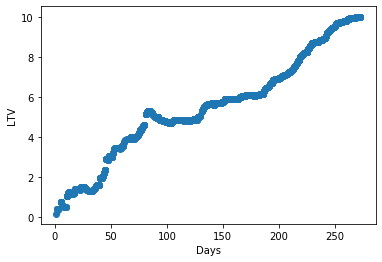

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(ltv_data['day'], ltv_data['ltv'])
plt.xlabel('Days')
plt.ylabel('LTV')

### Как видно, ltv - можно достаточно точно аппроксимировать даже линейной функцией.
Поэтому рассчитав коэффициент LTV_K_90_5 = LTV_AVG_90/LTV_AVG_5,
можно потом восстановить  даже по одной точке LTV_AVG_5.
Идеи улучшения - может более точно восстановить зависимость (логарифм..)